# Multi-layer Perceptron (MLP)

Implementation of Rosenblatt's Multi-layer Peceptron in Pytorch



In [1]:
import copy
import random
import time

import matplotlib.pyplot as plt
import numpy as np
from thop import profile
from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
import torchvision.datasets as datasets
from torchvision import transforms

In [2]:
GPU_ID=0
device = torch.device(f"cuda:{GPU_ID}" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

In [3]:
#fixed parameters
IMAGE_SIZE = 28  #MNIST image size
OUT_CLASSES = 10 #MNIST has 10 classes
INPUT_DIM = IMAGE_SIZE*IMAGE_SIZE
#train paparms
EPOCHS = 10
BATCH_SIZE = 64
#Misc. params
SEED = 42
DATA_DIR = 'data'

In [4]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
def generate_data():
    train_data = datasets.MNIST(root=DATA_DIR, train=True, 
                                download=True, transform=transforms.ToTensor())
    test_data = datasets.MNIST(root=DATA_DIR, train=False, 
                               download=True, transform=transforms.ToTensor())
    return train_data, test_data

In [6]:
train_data, test_data = generate_data()

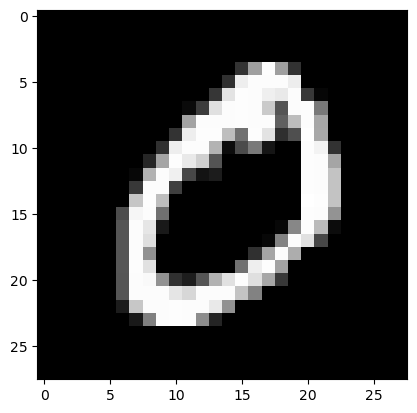

In [7]:
im = train_data[1][0]
plt.imshow(im.squeeze(0), cmap='gray')

In [8]:
#could experiment with different train/validation ratios
TRAIN_VAL_RATIO = 0.9

n_train = int(len(train_data) * TRAIN_VAL_RATIO)
n_valid = len(train_data) - n_train

In [9]:
train_data, valid_data = random_split(train_data, [n_train, n_valid])

In [10]:
valid_data = copy.deepcopy(valid_data)

In [11]:
train_iterator = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator = DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = DataLoader(test_data, batch_size=BATCH_SIZE)

Model size analysis

In [12]:
def count_parameters(net):
    total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    return total_params

In [13]:
def get_net_device(net):
    #after mcunet
    return net.parameters().__next__().device

[MACs are multiply-accumulate operations](https://openaccess.thecvf.com/content/CVPR2022W/NAS/papers/Liu_Network_Amplification_With_Efficient_MACs_Allocation_CVPRW_2022_paper.pdf)


In [14]:
def count_net_flops(model, data_shape):
    #after mcunet
    model = copy.deepcopy(model)
    total_macs, _ = profile(
        model,
        inputs=(torch.randn(*data_shape).to(get_net_device(model)),),
        verbose=False,
    )
    del model
    return total_macs

### Define NN architecture

In [15]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_in, hidden_out, out_classes):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(input_dim, hidden_in),   #input layer
          nn.ReLU(),
          nn.Linear(hidden_in, hidden_out),  #hidden layer
          nn.ReLU(),
          nn.Linear(hidden_out, out_classes) #output layer
        )

    def forward(self, x):
        y_pred = self.layers(x)
        return y_pred

In [16]:
class MLP_2_Hidden(nn.Module):
    def __init__(self, input_dim, hidden_1_in, hidden_1_out, hidden_2_out, out_classes):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(input_dim, hidden_1_in),            #input layer
          nn.ReLU(),
          nn.Linear(hidden_1_in, hidden_1_out),         #hidden layer 1
          nn.ReLU(),
          nn.Linear(hidden_1_out, hidden_2_out),        #hidden layer 2
          nn.ReLU(),
          nn.Linear(hidden_2_out, out_classes)                   #output layer
        )

    def forward(self, x):
        y_pred = self.layers(x)
        return y_pred

In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:
def calc_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [19]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        acc = calc_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [20]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            acc = calc_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [21]:
def train_val_workflow(model, model_save_name):
    best_valid_loss = float('inf') #unbound upper value
    for epoch in range(EPOCHS):
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), model_save_name)
        print(f'Epoch: {epoch}, Train Loss: {train_loss:.2f}, Val. Loss: {valid_loss:.2f}, Train Acc: {train_acc*100:.2f}%, Val. Acc: {valid_acc*100:.2f}%')

### MLP with 1 hidden layer

In [22]:
#test these parameters
hidden_in=128
hidden_out=32

In [23]:
model = MLP(INPUT_DIM, hidden_in, hidden_out, OUT_CLASSES)

In [24]:
model = model.to(device)
criterion = criterion.to(device)

In [25]:
optimizer = optim.Adam(model.parameters())

In [26]:
#MNIST has only 1 channel
data_shape=(BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE)
print(f'Parameters: {count_parameters(model)}, MACS: {count_net_flops(model, data_shape)}')

Parameters: 104938, MACS: 6705152.0


In [27]:
train_val_workflow(model, model_save_name='mlp-model.pt')

Epoch: 0, Train Loss: 0.38, Val. Loss: 0.20, Train Acc: 89.49%, Val. Acc: 94.17%
Epoch: 1, Train Loss: 0.15, Val. Loss: 0.14, Train Acc: 95.59%, Val. Acc: 95.94%
Epoch: 2, Train Loss: 0.11, Val. Loss: 0.13, Train Acc: 96.87%, Val. Acc: 95.90%
Epoch: 3, Train Loss: 0.08, Val. Loss: 0.11, Train Acc: 97.52%, Val. Acc: 96.48%
Epoch: 4, Train Loss: 0.06, Val. Loss: 0.10, Train Acc: 97.97%, Val. Acc: 97.02%
Epoch: 5, Train Loss: 0.05, Val. Loss: 0.09, Train Acc: 98.44%, Val. Acc: 97.25%
Epoch: 6, Train Loss: 0.04, Val. Loss: 0.10, Train Acc: 98.70%, Val. Acc: 97.14%
Epoch: 7, Train Loss: 0.04, Val. Loss: 0.10, Train Acc: 98.86%, Val. Acc: 96.92%
Epoch: 8, Train Loss: 0.03, Val. Loss: 0.11, Train Acc: 99.07%, Val. Acc: 96.99%
Epoch: 9, Train Loss: 0.02, Val. Loss: 0.10, Train Acc: 99.34%, Val. Acc: 97.37%


In [28]:
model.load_state_dict(torch.load('mlp-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.086, Test Acc: 97.45%


### MLP with 2 hidden layers

In [29]:
#test these parameters
batch_size = 64
hidden_1_in = 128
hidden_1_out = 64
hidden_2_out = 32

In [30]:
model = MLP_2_Hidden(INPUT_DIM, hidden_1_in, hidden_1_out, hidden_2_out, OUT_CLASSES)

In [31]:
model = model.to(device)
criterion = criterion.to(device)

In [32]:
optimizer = optim.Adam(model.parameters())

In [33]:
train_val_workflow(model, model_save_name='mlp-2h-model.pt')

Epoch: 0, Train Loss: 0.40, Val. Loss: 0.20, Train Acc: 88.37%, Val. Acc: 94.08%
Epoch: 1, Train Loss: 0.15, Val. Loss: 0.15, Train Acc: 95.40%, Val. Acc: 95.68%
Epoch: 2, Train Loss: 0.11, Val. Loss: 0.13, Train Acc: 96.79%, Val. Acc: 96.14%
Epoch: 3, Train Loss: 0.08, Val. Loss: 0.11, Train Acc: 97.43%, Val. Acc: 96.62%
Epoch: 4, Train Loss: 0.07, Val. Loss: 0.11, Train Acc: 97.90%, Val. Acc: 96.77%
Epoch: 5, Train Loss: 0.05, Val. Loss: 0.11, Train Acc: 98.33%, Val. Acc: 96.97%
Epoch: 6, Train Loss: 0.05, Val. Loss: 0.11, Train Acc: 98.52%, Val. Acc: 96.76%
Epoch: 7, Train Loss: 0.04, Val. Loss: 0.10, Train Acc: 98.79%, Val. Acc: 97.12%
Epoch: 8, Train Loss: 0.03, Val. Loss: 0.13, Train Acc: 99.02%, Val. Acc: 96.52%
Epoch: 9, Train Loss: 0.03, Val. Loss: 0.11, Train Acc: 99.09%, Val. Acc: 97.02%


In [34]:
model.load_state_dict(torch.load('mlp-2h-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.095, Test Acc: 97.24%
